In [ ]:
!pip install --upgrade google-cloud-bigquery


In [ ]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:

from google.cloud import bigquery
import pandas as pd

# Tentukan Project ID Anda
project_id = "deep-care-capstone"

# Inisialisasi BigQuery Client
client = bigquery.Client(project=project_id)

In [ ]:
# Jalankan Query
query = """
WITH trip_data AS (
SELECT
EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week,
trip_seconds
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (2, 7) -- 2 = Monday, 7 = Saturday
)
SELECT
CASE
WHEN day_of_week = 2 THEN 'Monday'
WHEN day_of_week = 7 THEN 'Saturday'
END AS day_name,
COUNT(*) AS num_trips,
AVG(trip_seconds) AS avg_trip_seconds,
APPROX_QUANTILES(trip_seconds, 2)[OFFSET(1)] AS median_trip_seconds,
STDDEV(trip_seconds) AS stddev_trip_seconds
FROM
trip_data
GROUP BY
day_of_week
ORDER BY
day_of_week;
"""
df1 = client.query(query).to_dataframe()

# Tampilkan data
df1.head()

,day_name,num_trips,avg_trip_seconds,median_trip_seconds,stddev_trip_seconds
0,Monday,27315537,839.479784,540,1346.060208
1,Saturday,30678201,737.410552,540,1146.335888


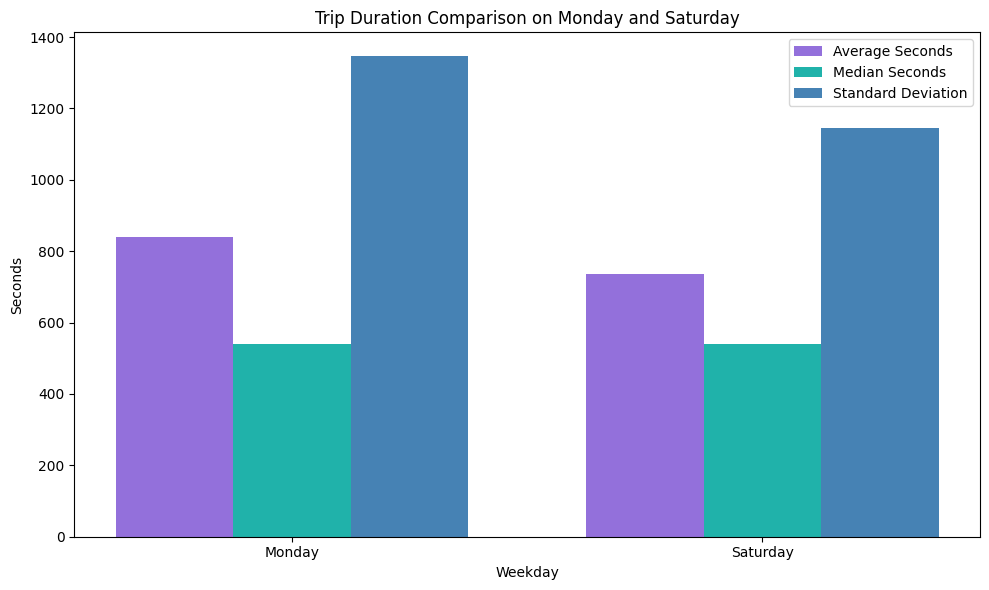

In [ ]:
import numpy as np

# Data extracted from the DataFrame df1
weekdays = df1['day_name']  # Corrected column name
avg_seconds = df1['avg_trip_seconds']  # Corrected column name
median_seconds = df1['median_trip_seconds']  # Corrected column name
stddev_seconds = df1['stddev_trip_seconds']  # Corrected column name

# X-axis positions for the bars
x = np.arange(len(weekdays))
width = 0.25  # Width of the bars

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(x - width, avg_seconds, width, label='Average Seconds', color='mediumpurple')
bar2 = ax.bar(x, median_seconds, width, label='Median Seconds', color='lightseagreen')
bar3 = ax.bar(x + width, stddev_seconds, width, label='Standard Deviation', color='steelblue')

# Adding labels and title
ax.set_xlabel('Weekday')
ax.set_ylabel('Seconds')
ax.set_title('Trip Duration Comparison on Monday and Saturday')
ax.set_xticks(x)
ax.set_xticklabels(weekdays)

# Adding the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
query = """
SELECT
  pickup_community_area,
  dropoff_community_area,
  COUNT(*) AS num_trips
FROM
  bigquery-public-data.chicago_taxi_trips.taxi_trips
WHERE
  pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND EXTRACT(year FROM trip_start_timestamp) = 2023
GROUP BY
  pickup_community_area,
  dropoff_community_area
ORDER BY
  num_trips DESC
LIMIT
  5;
"""
df2 = client.query(query).to_dataframe()

# Tampilkan data
df2.head()

,pickup_community_area,dropoff_community_area,num_trips
0,8,8,464844
1,32,8,291722
2,76,8,274747
3,8,32,267673
4,32,32,241596


<ipython-input-13-d0b149dde753>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=routes, y=num_trips, palette="Blues_d")


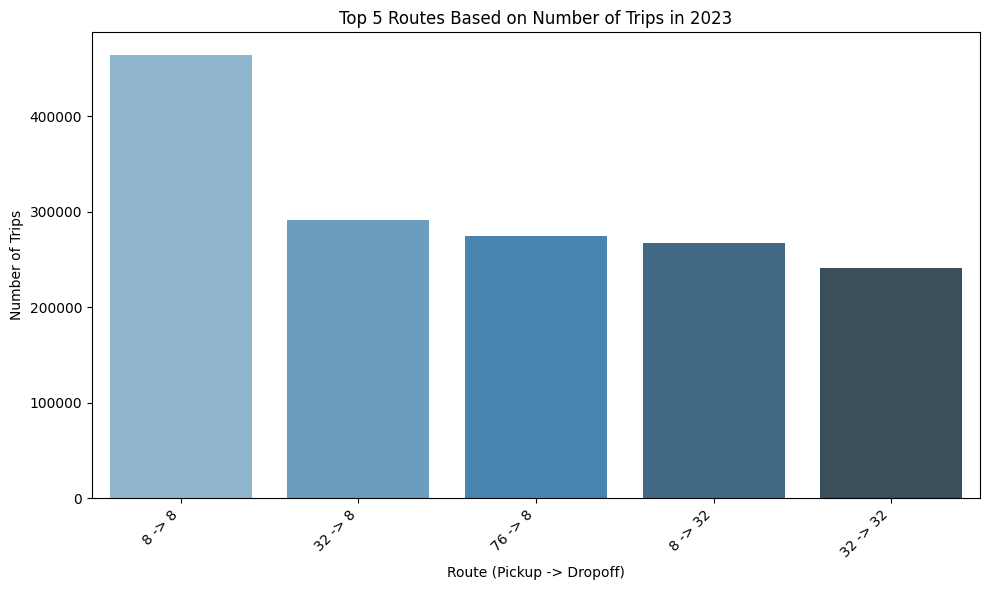

In [ ]:

# Data extracted from the DataFrame df2
pickup_community_area = df2['pickup_community_area']
dropoff_community_area = df2['dropoff_community_area']
num_trips = df2['num_trips']

# Create a string for each route combining pickup and dropoff area
routes = pickup_community_area.astype(str) + ' -> ' + dropoff_community_area.astype(str)

# Create the figure and the axes
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x=routes, y=num_trips, palette="Blues_d")

# Adding labels and title
plt.xlabel('Route (Pickup -> Dropoff)')
plt.ylabel('Number of Trips')
plt.title('Top 5 Routes Based on Number of Trips in 2023')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

# Jalankan Query
query = """
SELECT
  payment_type,
  AVG(fare) AS average_fare,
  AVG(tips) AS average_tips,
  AVG(tolls) AS average_tolls
FROM
  bigquery-public-data.chicago_taxi_trips.taxi_trips
WHERE
  EXTRACT(year FROM trip_start_timestamp) = 2019
GROUP BY
  payment_type
ORDER BY
  average_fare DESC;
"""
df3 = client.query(query).to_dataframe()

# Tampilkan data
df3.head(10)

,payment_type,average_fare,average_tips,average_tolls
0,Prepaid,19.461415,0.000000,0.000000
1,Credit Card,16.814138,3.774545,0.002267
2,Prcard,16.130003,0.203528,0.001529
3,Mobile,15.973174,3.112698,0.000050
4,Unknown,15.872380,0.082129,0.000147
5,No Charge,15.753510,0.249532,0.019142
6,Dispute,15.655840,0.001446,0.078991
7,Cash,12.978306,0.002387,0.001791
8,Pcard,11.327471,0.038023,0.000000


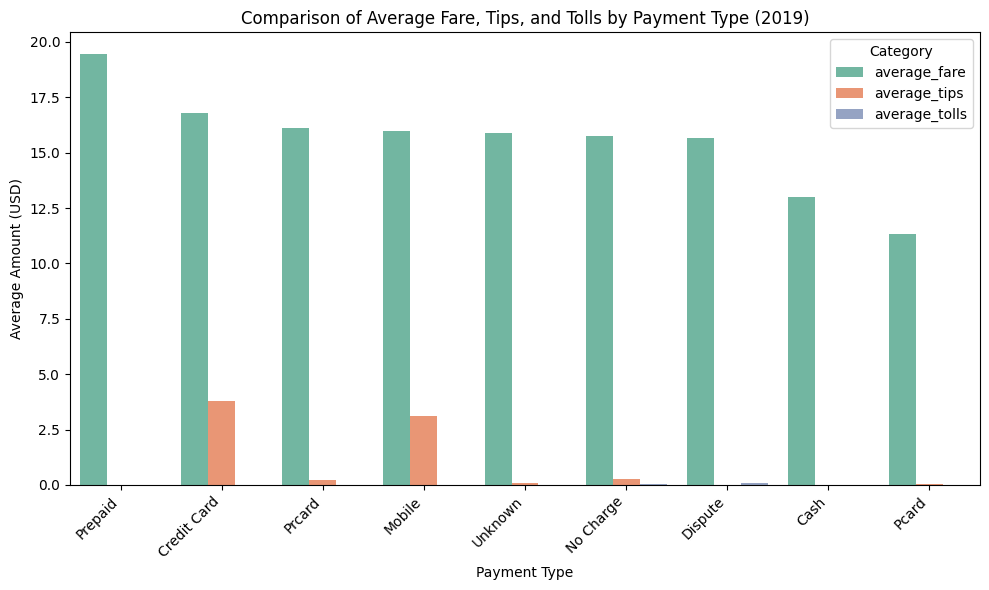

In [ ]:

# Data extracted from the DataFrame df3
payment_type = df3['payment_type']
average_fare = df3['average_fare']
average_tips = df3['average_tips']
average_tolls = df3['average_tolls']

# Create a DataFrame for easier plotting
df_plot = df3.melt(id_vars='payment_type', value_vars=['average_fare', 'average_tips', 'average_tolls'],
                   var_name='Category', value_name='Amount')

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a grouped bar plot using seaborn
sns.barplot(x='payment_type', y='Amount', hue='Category', data=df_plot, palette="Set2")

# Add labels and title
plt.xlabel('Payment Type')
plt.ylabel('Average Amount (USD)')
plt.title('Comparison of Average Fare, Tips, and Tolls by Payment Type (2019)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the legend and plot
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [ ]:

# Jalankan Query
query = """
SELECT
  FORMAT_TIMESTAMP('%A', trip_start_timestamp) AS day_of_week,
  COUNT(*) AS trip_count
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp IS NOT NULL
GROUP BY
  day_of_week
ORDER BY
  CASE
    WHEN day_of_week = 'Sunday' THEN 1
    WHEN day_of_week = 'Monday' THEN 2
    WHEN day_of_week = 'Tuesday' THEN 3
    WHEN day_of_week = 'Wednesday' THEN 4
    WHEN day_of_week = 'Thursday' THEN 5
    WHEN day_of_week = 'Friday' THEN 6
    WHEN day_of_week = 'Saturday' THEN 7
  END ASC;
"""
df_day = client.query(query).to_dataframe()

# Tampilkan data
df_day.head(7)

,day_of_week,trip_count
0,Sunday,25422681
1,Monday,27315537
2,Tuesday,29542584
3,Wednesday,30927202
4,Thursday,32764821
5,Friday,35004433
6,Saturday,30678201


<ipython-input-17-e991d8c2cbeb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='trip_count', data=df_day, palette='viridis')


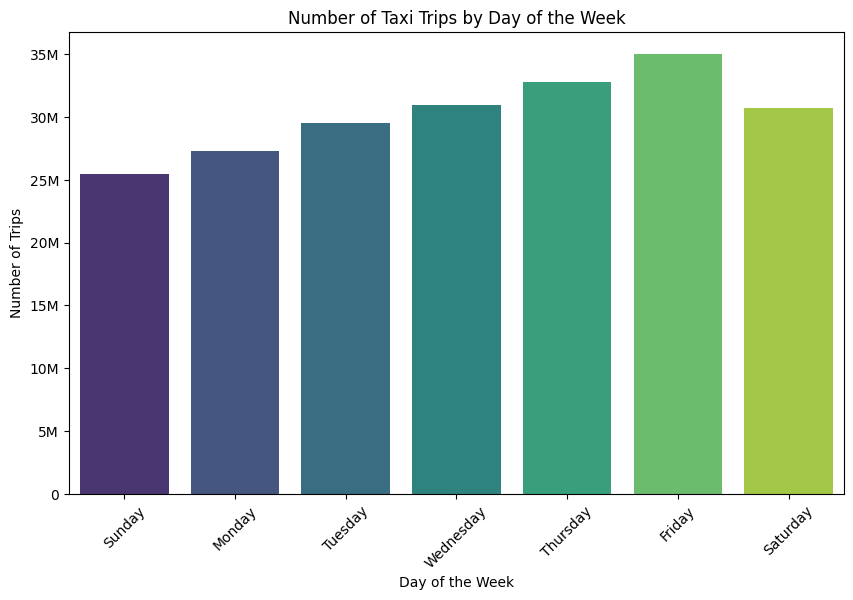

In [ ]:

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='trip_count', data=df_day, palette='viridis')

# Change format y-axis in %%M (%% million)
def format_million(x, pos):
    if x >= 1e6:
        return '{:.0f}M'.format(x * 1e-6)
    else:
        return '{:.0f}'.format(x)

formatter = ticker.FuncFormatter(format_million)
plt.gca().yaxis.set_major_formatter(formatter)

# Customize the plot
plt.title('Number of Taxi Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Jalankan Query
query = """
SELECT
  FORMAT_TIMESTAMP('%B', trip_start_timestamp) AS month,
  COUNT(*) AS trip_count
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp IS NOT NULL
GROUP BY
  month
ORDER BY
  CASE
    WHEN month = 'January' THEN 1
    WHEN month = 'February' THEN 2
    WHEN month = 'March' THEN 3
    WHEN month = 'April' THEN 4
    WHEN month = 'May' THEN 5
    WHEN month = 'June' THEN 6
    WHEN month = 'July' THEN 7
    WHEN month = 'August' THEN 8
    WHEN month = 'September' THEN 9
    WHEN month = 'October' THEN 10
    WHEN month = 'November' THEN 11
    WHEN month = 'December' THEN 12
  END ASC;
"""
df_month = client.query(query).to_dataframe()

# Tampilkan data
df_month.head(12)

,month,trip_count
0,January,15988857
1,February,16494338
2,March,18927609
3,April,17751333
4,May,18947867
5,June,19075435
6,July,17647422
7,August,17908914
8,September,17332324
9,October,18776583


<ipython-input-19-424f6ee1cb70>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='trip_count', data=df_month, palette='coolwarm')


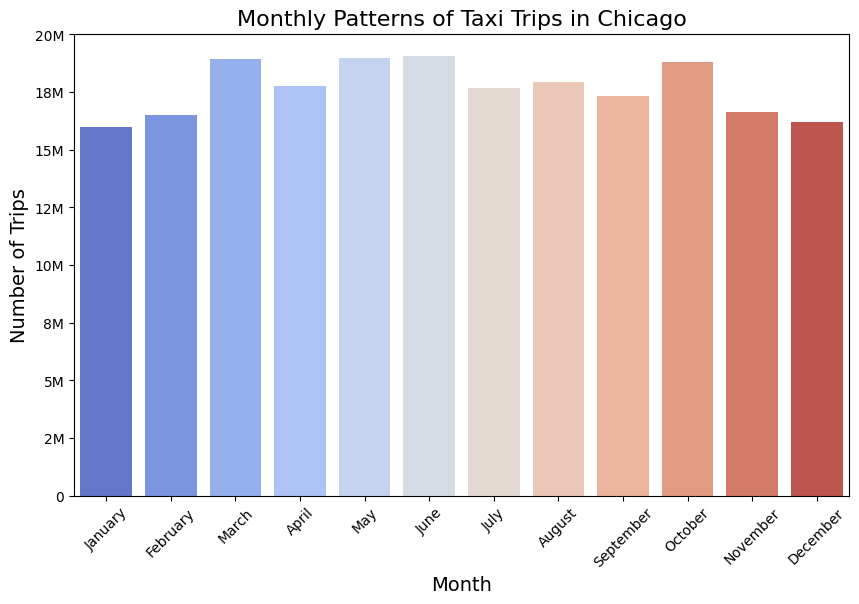

In [ ]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='trip_count', data=df_month, palette='coolwarm')

# Change format y-axis in %%M (%% million)
formatter = ticker.FuncFormatter(format_million)
plt.gca().yaxis.set_major_formatter(formatter)

# Customize the plot
plt.title('Monthly Patterns of Taxi Trips in Chicago', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Jalankan Query
query = """
SELECT
  CASE
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (9, 10, 11) THEN 'Fall'
  END AS season,
  COUNT(*) AS trip_count
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp IS NOT NULL
GROUP BY
  season
ORDER BY
  CASE
    WHEN season = 'Winter' THEN 1
    WHEN season = 'Spring' THEN 2
    WHEN season = 'Summer' THEN 3
    WHEN season = 'Fall' THEN 4
  END ASC;
"""
df_season = client.query(query).to_dataframe()

# Tampilkan data
df_season.head(7)


,season,trip_count
0,Winter,48657723
1,Spring,55626809
2,Summer,54631771
3,Fall,52739156


<ipython-input-21-54b57bfbd77f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='season', y='trip_count', data=df_season, palette='Set3')


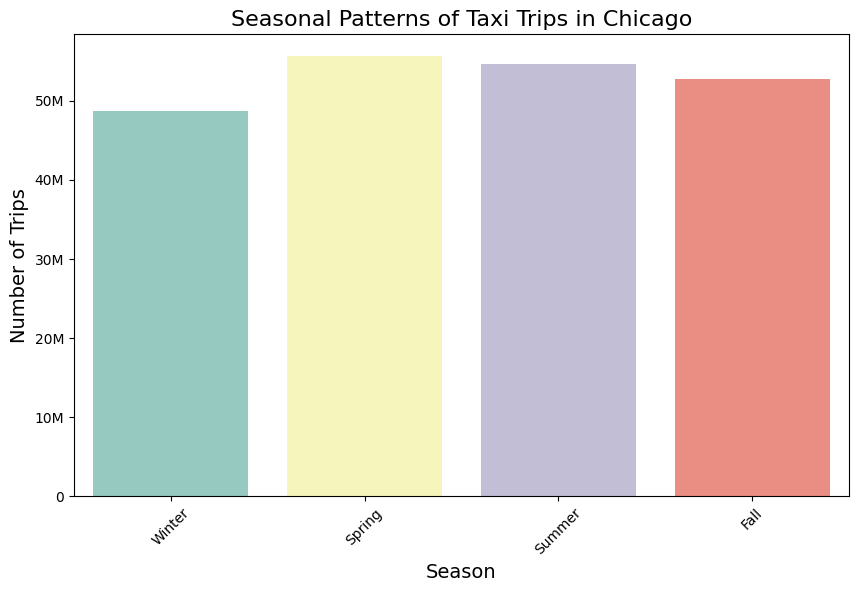

In [ ]:

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='trip_count', data=df_season, palette='Set3')

# Change format y-axis in %%M (%% million)
formatter = ticker.FuncFormatter(format_million)
plt.gca().yaxis.set_major_formatter(formatter)

# Customize the plot
plt.title('Seasonal Patterns of Taxi Trips in Chicago', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Jalankan Query
query = """
SELECT
  company,
  sum(trip_total) AS total_revenue
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  company IS NOT NULL
  AND trip_total IS NOT NULL
GROUP BY
  company
ORDER BY
  total_revenue DESC
LIMIT
  10;
"""
df_5 = client.query(query).to_dataframe()

# Tampilkan data
df_5.head(10)

,company,total_revenue
0,Taxi Affiliation Services,6.919677e+08
1,Flash Cab,3.707280e+08
2,Dispatch Taxi Affiliation,1.453281e+08
3,Yellow Cab,1.448470e+08
4,Blue Ribbon Taxi Association Inc.,1.427294e+08
5,Sun Taxi,1.404367e+08
6,Chicago Carriage Cab Corp,1.396268e+08
7,City Service,1.320829e+08
8,Choice Taxi Association,1.296312e+08
9,Medallion Leasin,1.080547e+08


<ipython-input-23-1931c33cd433>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_revenue, y=company, palette="Set1")


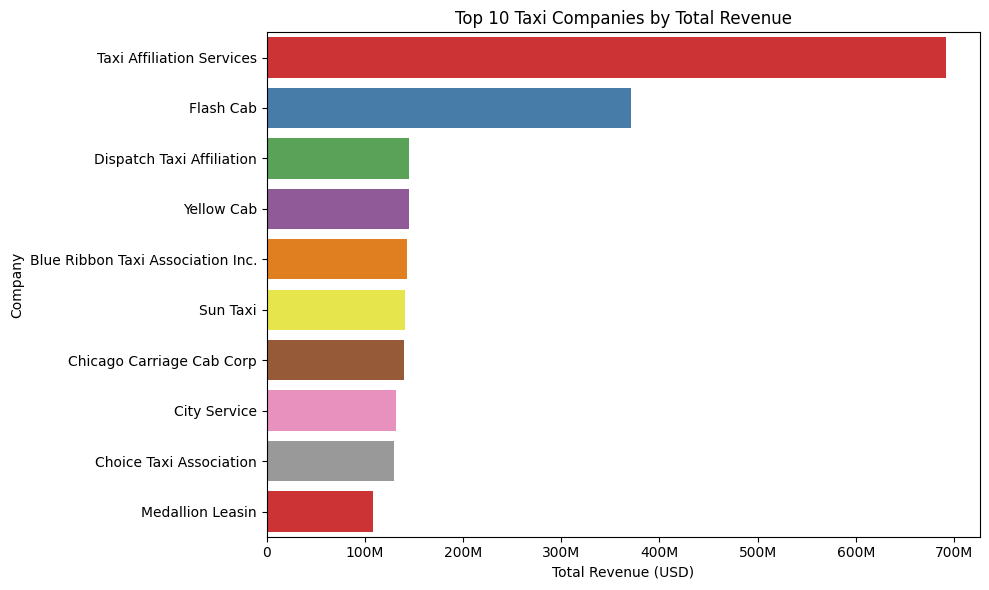

In [ ]:
# Data for plotting from the DataFrame df_5
company = df_5['company']
total_revenue = df_5['total_revenue']

# Set figure size
plt.figure(figsize=(10, 6))

# Create a bar plot using seaborn
sns.barplot(x=total_revenue, y=company, palette="Set1")

# Change format x-axis in %%M (%% million)
def format_x_million(y, pos):
    if y >= 1e6:
        return '{:.0f}M'.format(y * 1e-6)
    else:
        return '{:.0f}'.format(y)

formatter = ticker.FuncFormatter(format_x_million)
plt.gca().xaxis.set_major_formatter(formatter)

# Add labels and title
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Company')
plt.title('Top 10 Taxi Companies by Total Revenue')

# Display the chart
plt.tight_layout()
plt.show()